[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/nmfs-opensci/nmfshackdays-2025/blob/main/topics-2025/2025-opendap/1-ncep-ncar.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link]

[download-link]: https://nmfs-opensci.github.io/NMFSHackDays-2025/topics-2025/2025-opendap/1-ncep-ncar.ipynb
[colab-link]: https://colab.research.google.com/github/nmfs-opensci/nmfshackdays-2025/blob/main/topics-2025/2025-opendap/1-ncep-ncar.ipynb
[jupyter-link]: https://nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/nmfs-opensci/nmfshackdays-2025/main/topics-2025/2025-opendap/1-ncep-ncar.ipynb

>📘 Learning Objectives
>
> 1. Practice working with data on THREDDS and OPeNDAP servers
> 2. Open a single file
> 3. Create a data cube using urls to multiple files
> 4. Do some basic data aggregation.

## Overview

THREDDS is a common type of data server that usually includes multiple ways to access the data. One of those ways is via the OPeNDAP protocol which allows you to subset the data, instead of downloading the whole data file. Here you will learn to use `xarray`'s `open_mfdataset` to create data cubes on THREDDS servers using the OPeNDAP protocol. This tutorial uses an example where the server doesn't require authentication (username and password).

*Acknowledgments:* This example was adapted from Ryan Abernathy <https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html>

## NCEP-NCAR Reanalysis 1

For our first example, we will use 4xDaily Air temperature at sigma level 995 data (`air.sig995`) from the [NCEP-NCAR Reanalysis 1](NCEP-NCAR Reanalysis 1). First look at the [THREDDS catalog](https://psl.noaa.gov/thredds/catalog/Datasets/ncep.reanalysis/surface/catalog.html) to orient yourself to the file naming convention. We can click on one of the files an see our [access options]. We are looking for the OPeNDAP information as we need to get the url for that. Clicking the [OPeNDAP link](https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1948.nc.html) reveals the url format of the files:
```
https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1948.nc
```

Now we can create the file urls.

In [1]:
import xarray as xr

In [2]:
base_url = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995'

files = [f'{base_url}.{year}.nc' for year in range(1948, 2025)]
len(files)

77

Open a single file.

In [10]:
files[0]

'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1948.nc'

In [3]:
%%time
ds = xr.open_dataset(files[0]);
ds

CPU times: user 768 ms, sys: 55.9 ms, total: 824 ms
Wall time: 2.58 s


<xarray.Dataset> Size: 62MB
Dimensions:  (lon: 144, time: 1464, lat: 73)
Coordinates:
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 12kB 1948-01-01 ... 1948-12-31T18:00:00
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    air      (time, lat, lon) float32 62MB ...
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (1948)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    history:                         created 99/05/11 by Hoop (netCDF2.3)\nCo...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    DODS_EXTRA.Unlimited_Dimension:  time

We will load the file metadata with `open_mfdataset` and create our virtual data cube. It will take 10 seconds or so but it doesn't use much memory as we are only reading and loading the file metadata.

In [4]:
%%time
ds = xr.open_mfdataset(files, parallel=True);

CPU times: user 2.09 s, sys: 275 ms, total: 2.37 s
Wall time: 28.4 s


In [6]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:  (time: 112500, lat: 73, lon: 144)
Coordinates:
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 900kB 1948-01-01 ... 2024-12-31T18:00:00
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    air      (time, lat, lon) float32 5GB dask.array<chunksize=(1464, 73, 144), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (1948)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    history:                         created 99/05/11 by Hoop (netCDF2.3)\nCo...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    DODS_EXTRA.Unlimited_Dimension:  time

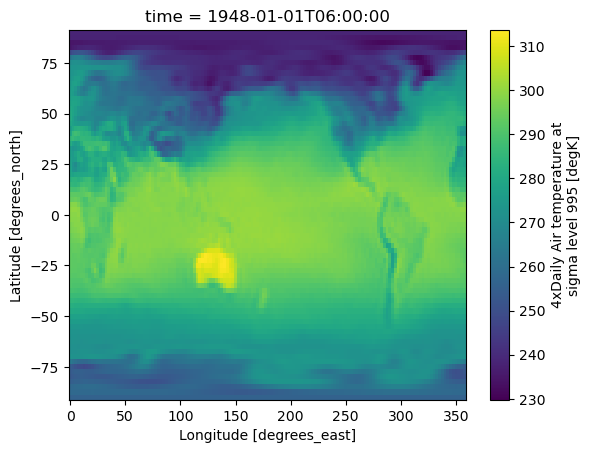

In [5]:
ds['air'].isel(time=1).plot();

The data set is not that huge, but it is bigger than the 2Gb RAM in our minimal Jupyter Hub.

In [7]:
print(f"{ds.nbytes / 1e9} Gb")

4.731300868 Gb


But even a small dataset would crash our 2Gb RAM.

In [4]:
ds_sub = ds.sel(time=slice("1948","1958"))
print(f"{ds_sub.nbytes / 1e9} Gb")
# ds_sub.load() # this would crash a 2Gb RAM

0.6759249 Gb


## Creating daily means

For one year, we can create a daily mean since 1 year is not that much data and we can fit that into memory.

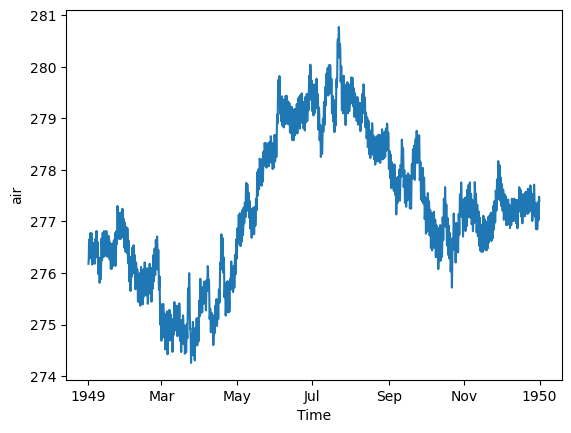

In [7]:
ds_mean = ds["air"].sel(time="1949").mean(dim=['lat', 'lon'])
ds_mean.plot();

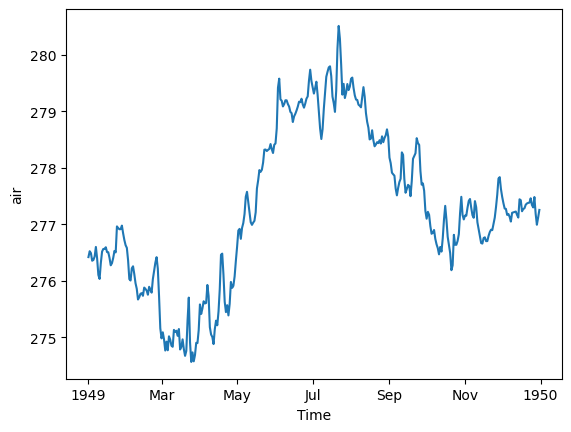

In [8]:
# resample to daily
ds_mean.resample(time='D').mean().plot();

But if we try to do all years at once, we will run out of memory.

### Chunking the data

Fortunately, `xarray` will process our data in chunks rather than loading the whole data into memory. The data were chunked automatically into yearly chunks by `xarray` since we created using `open_mfdataset`. The chunks are 1460 = 4 x 365 days since the files are one year. 

In [8]:
print(ds["air"].chunks)

((1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464), (73,), (144,))


I am going to rechunk smaller to get to about 1 Mb sized chunks. This should make it go a little faster and use a little less memory.

In [3]:
import dask
ds_chunk = ds["air"].sel(time=slice("1948", "1958")).chunk({'time': 24, 'lat': -1, 'lon': -1})
ds_chunk

<xarray.DataArray 'air' (time: 16072, lat: 73, lon: 144)> Size: 676MB
dask.array<rechunk-merge, shape=(16072, 73, 144), dtype=float32, chunksize=(24, 73, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 129kB 1948-01-01 ... 1958-12-31T18:00:00
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]

In [4]:
# This is takes about 4 minutes; 1.4 Gb
from dask.diagnostics import ProgressBar

with ProgressBar():
    mean_all_years = ds_chunk.mean(dim=['lat', 'lon']).compute()

[########################################] | 100% Completed | 218.60 s


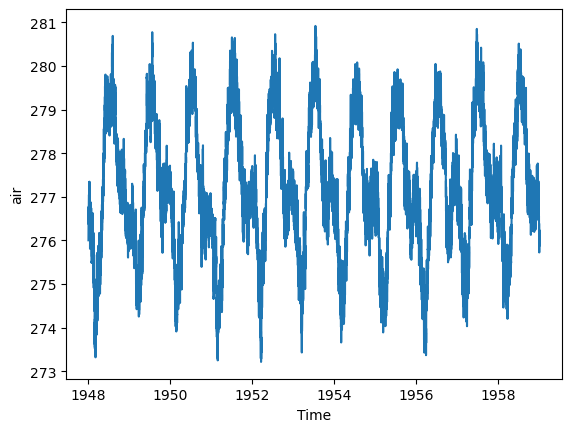

In [6]:
mean_all_years.plot();

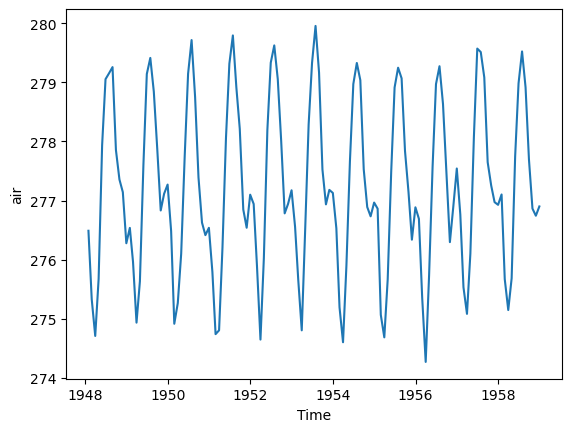

In [7]:
# resample to monthly
mean_all_years.resample(time='ME').mean().plot();

## Conclusion

We practiced creating data cubes with urls to files on a THREDDS server via the OPeNDAP protocol.

## References

* <https://www.jamstec.go.jp/ridinfo/xarray-and-opendap/>
* More opendap + xarray debugging <https://github.com/stuckyb/gcdl/issues/24>
* Another opendap example <https://github.com/ornldaac/daymet-python-opendap-xarray/blob/master/1_daymetv4_discovery_access_subsetting.ipynb>
* Nice example <https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html>

